<a href="https://colab.research.google.com/github/cloverbunny/cccf2025/blob/main/Density_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
auth.authenticate_user()

In [ ]:
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'silent-bolt-397621'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

In [ ]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [ ]:
query_density="""
WITH selected_items AS (
  SELECT itemid, label
  FROM `physionet-data.mimiciv_3_1_icu.d_items`
  WHERE label IN (
    'Chest X-Ray',
    'Portable Chest X-Ray',
    'EKG',
    'Arterial Line',
    'Blood Cultured',
    'Multi Lumen',
    'Foley Catheter',
    'PICC Line',
    'Urine Culture',
    'Ultrasound',
    'PA Catheter',
    'Cordis/Introducer',
    'Stool Culture',
    'Sheath (Venous)',
    'MAC',
    'Temporary Pacemaker Wires Inserted',
    'Temporary Pacemaker Wires Discontinued'
  )
),

proc_per_stay AS (
  SELECT
    pe.itemid,
    di.label AS item_label,
    pe.subject_id,
    pe.hadm_id,
    pe.stay_id,
    COUNT(*) AS event_count
  FROM `physionet-data.mimiciv_3_1_icu.procedureevents` pe
  JOIN selected_items di USING (itemid)
  GROUP BY pe.itemid, di.label, pe.subject_id, pe.hadm_id, pe.stay_id
),

stays AS (
  SELECT
    subject_id,
    hadm_id,
    stay_id,
    los
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  WHERE outtime IS NOT NULL
    AND los > (2/24.0)
)

SELECT
  p.itemid,
  p.item_label,
  p.subject_id,
  p.hadm_id,
  p.stay_id,
  p.event_count,
  s.los,
  SAFE_DIVIDE(p.event_count, s.los) AS density
FROM proc_per_stay p

JOIN stays s USING (subject_id, hadm_id, stay_id)
ORDER BY p.item_label, density DESC;
"""

In [ ]:
query_dn="""
WITH base AS (
  SELECT
    stay_id,
    charttime,
    'dni' AS decision_type,
    dni AS value
  FROM `physionet-data.mimiciv_3_1_derived.code_status`
  UNION ALL
  SELECT
    stay_id,
    charttime,
    'dnr' AS decision_type,
    dnr AS value
  FROM `physionet-data.mimiciv_3_1_derived.code_status`
),

ordered AS (
  SELECT
    *,
    LAG(value) OVER (
      PARTITION BY stay_id, decision_type ORDER BY charttime
    ) AS prev_value
  FROM base
),

change_to_1 AS (
  SELECT
    stay_id,
    decision_type,
    charttime,
    value,
    -- Check if any future value becomes 0
    MIN(value) OVER (
      PARTITION BY stay_id, decision_type
      ORDER BY charttime
      ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
    ) AS min_future_value
  FROM ordered
  WHERE prev_value = 0 AND value = 1
),

-- Keep only stable 1 transitions
stable AS (
  SELECT
    stay_id,
    decision_type,
    charttime,
    value
  FROM change_to_1
  WHERE min_future_value = 1
)

SELECT
  s.stay_id,
  s.decision_type,
  s.charttime,
  s.value,
  -- Day into ICU (decimal, 1 dp)
  ROUND(
    TIMESTAMP_DIFF(s.charttime, i.intime, SECOND) / 86400,
    0
  ) AS dayX,
i.los AS LOS,

  -- Journey percentage (dayX / LOS)
  ROUND(
    (TIMESTAMP_DIFF(s.charttime, i.intime, SECOND) / 86400) / i.los,
    3
  ) AS journey_pct

FROM stable s
JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
  ON s.stay_id = i.stay_id
WHERE s.stay_id IS NOT NULL
ORDER BY stay_id, decision_type, charttime;
"""

In [ ]:
query_density_pre_dni="""
WITH selected_items AS (
  SELECT itemid, label
  FROM `physionet-data.mimiciv_3_1_icu.d_items`
  WHERE label IN (
    'Chest X-Ray',
    'Portable Chest X-Ray',
    'EKG',
    'Arterial Line',
    'Blood Cultured',
    'Multi Lumen',
    'Foley Catheter',
    'PICC Line',
    'Urine Culture',
    'Ultrasound',
    'PA Catheter',
    'Cordis/Introducer',
    'Stool Culture',
    'Sheath (Venous)',
    'MAC',
    'Temporary Pacemaker Wires Inserted',
    'Temporary Pacemaker Wires Discontinued'
  )
),

proc_events AS (
  SELECT
    pe.itemid,
    di.label AS item_label,
    pe.subject_id,
    pe.hadm_id,
    pe.stay_id,
    pe.starttime AS charttime
  FROM `physionet-data.mimiciv_3_1_icu.procedureevents` pe
  JOIN selected_items di USING (itemid)
),

stays AS (
  SELECT subject_id, hadm_id, stay_id, los
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  WHERE outtime IS NOT NULL
    AND los > (2/24.0)
),

density AS (
  SELECT
    p.itemid,
    p.item_label,
    p.subject_id,
    p.hadm_id,
    p.stay_id,
    p.charttime,
    s.los
  FROM proc_events p
  JOIN stays s USING (subject_id, hadm_id, stay_id)
),

code_base AS (
  SELECT stay_id, charttime, 'dni' AS decision_type, dni AS value
  FROM `physionet-data.mimiciv_3_1_derived.code_status`
  UNION ALL
  SELECT stay_id, charttime, 'dnr', dnr
  FROM `physionet-data.mimiciv_3_1_derived.code_status`
),

code_ordered AS (
  SELECT
    *,
    LAG(value) OVER (
      PARTITION BY stay_id, decision_type ORDER BY charttime
    ) AS prev_value
  FROM code_base
),

change_to_1 AS (
  SELECT
    stay_id,
    decision_type,
    charttime,
    value,
    MIN(value) OVER (
      PARTITION BY stay_id, decision_type
      ORDER BY charttime
      ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
    ) AS min_future_value
  FROM code_ordered
  WHERE prev_value = 0 AND value = 1
),

stable AS (
  SELECT stay_id, decision_type, charttime
  FROM change_to_1
  WHERE min_future_value = 1
),

dni_cutoff AS (
  SELECT stay_id, charttime AS dni_charttime
  FROM stable
  WHERE decision_type = 'dni'
),

filtered AS (
  SELECT d.*
  FROM density d
  LEFT JOIN dni_cutoff c USING (stay_id)
  WHERE c.dni_charttime IS NULL
        OR d.charttime <= c.dni_charttime
),

density_final AS (
  SELECT
    item_label,
    stay_id,
    COUNT(*) AS event_count,
    ANY_VALUE(los) AS los,
    SAFE_DIVIDE(COUNT(*), ANY_VALUE(los)) AS density
  FROM filtered
  GROUP BY item_label, stay_id
)

SELECT *
FROM density_final
ORDER BY item_label, density DESC;
"""

In [ ]:
df_density=run_query(query_density)

/tmp/ipython-input-2060928785.py:3: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [ ]:
df_density_pre_dni=run_query(query_density_pre_dni)

/tmp/ipython-input-2060928785.py:3: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_density_violin(df, top_k=15):
    """
    Plots violin distributions of density for each item_label,
    with overlaid scatter points showing the top-K density values
    per label.

    Parameters
    ----------
    df_density : pd.DataFrame
        Must include columns:
        - item_label
        - density

    top_k : int
        Number of highest-density points to display per label.
    """

    # -------------------------------------
    # 1. Clean data
    # -------------------------------------
    df = df[df["density"].notnull()].copy()

    # Identify plotting order
    labels = df["item_label"].unique()

    # -------------------------------------
    # 2. Build violin groups
    # -------------------------------------
    groups = [
        df[df["item_label"] == label]["density"].values
        for label in labels
    ]

    # -------------------------------------
    # 3. Violin plot
    # -------------------------------------
    plt.figure(figsize=(17, 8))

    violin = plt.violinplot(
        groups,
        showmeans=False,
        showmedians=True,
        showextrema=True
    )

    # Aesthetic styling
    for body in violin['bodies']:
        body.set_facecolor("#d6fbd8")
        body.set_edgecolor("#808080")
        body.set_linewidth(0.8)
        body.set_alpha(0.9)

    for part in ('cmins', 'cmaxes', 'cbars', 'cmedians'):
        violin[part].set_color("#808080")
        violin[part].set_linewidth(1.1)

    # -------------------------------------
    # 4. Scatter: Top-K density values
    # -------------------------------------
    for i, label in enumerate(labels, start=1):
        subset = df[df["item_label"] == label]
        top_vals = subset.nlargest(top_k, "density")

        plt.scatter(
            np.full(len(top_vals), i),
            top_vals["density"].values,
            s=20,
            alpha=0.8
        )

    # -------------------------------------
    # 5. Formatting
    # -------------------------------------
    plt.xticks(
        ticks=range(1, len(labels) + 1),
        labels=labels,
        rotation=45,
        ha="right"
    )

    plt.ylabel("Density")
    plt.title("Procedure Count per Day (Dots = Top {} Values)".format(top_k))
    plt.tight_layout()
    plt.show()

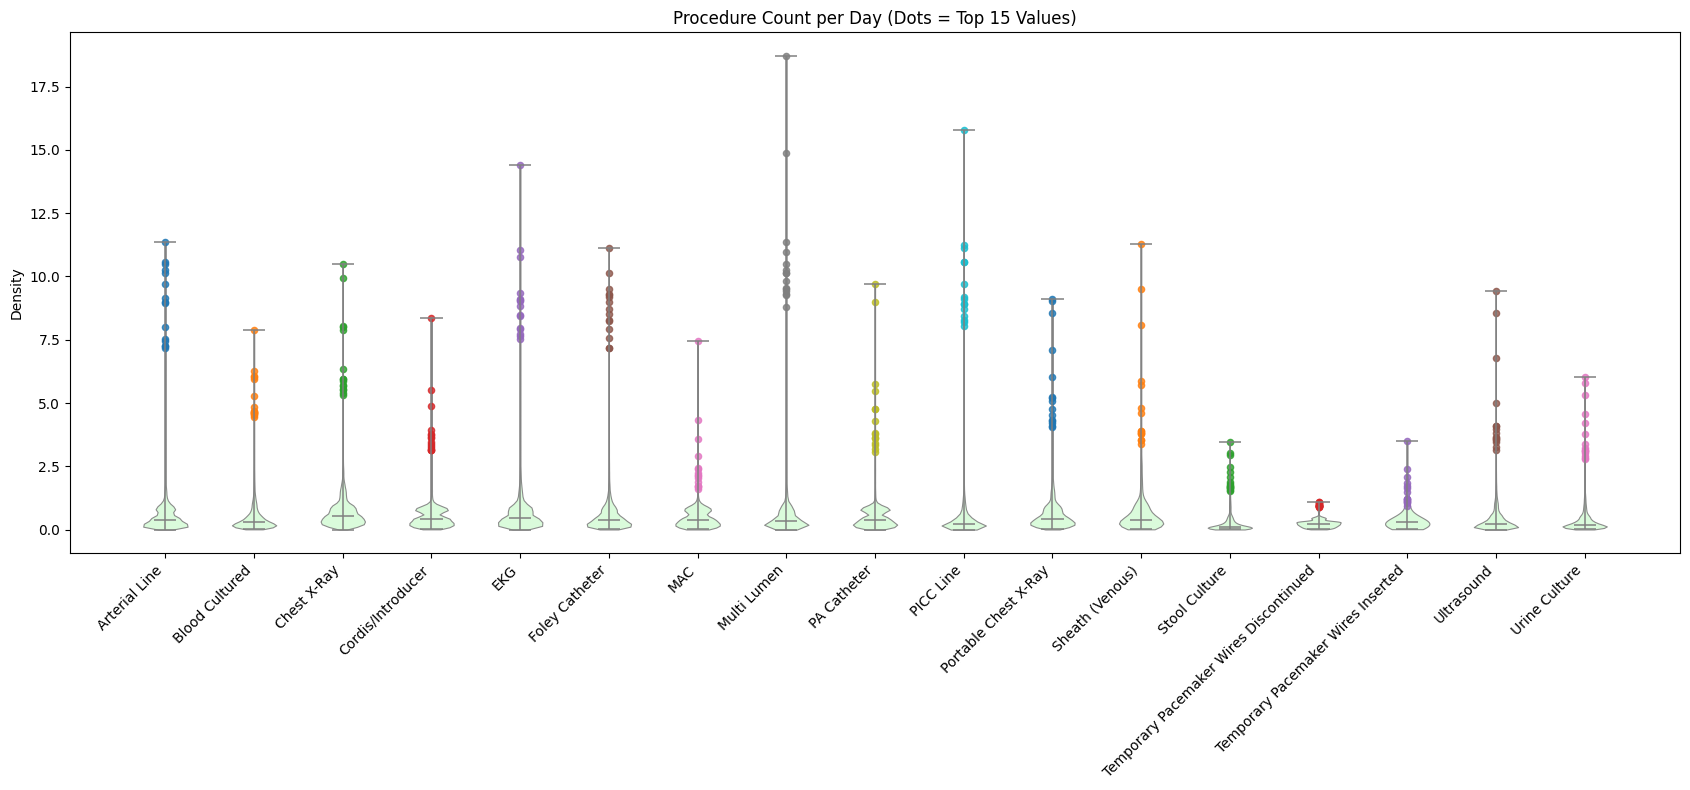

In [ ]:
plot_density_violin(df_density)

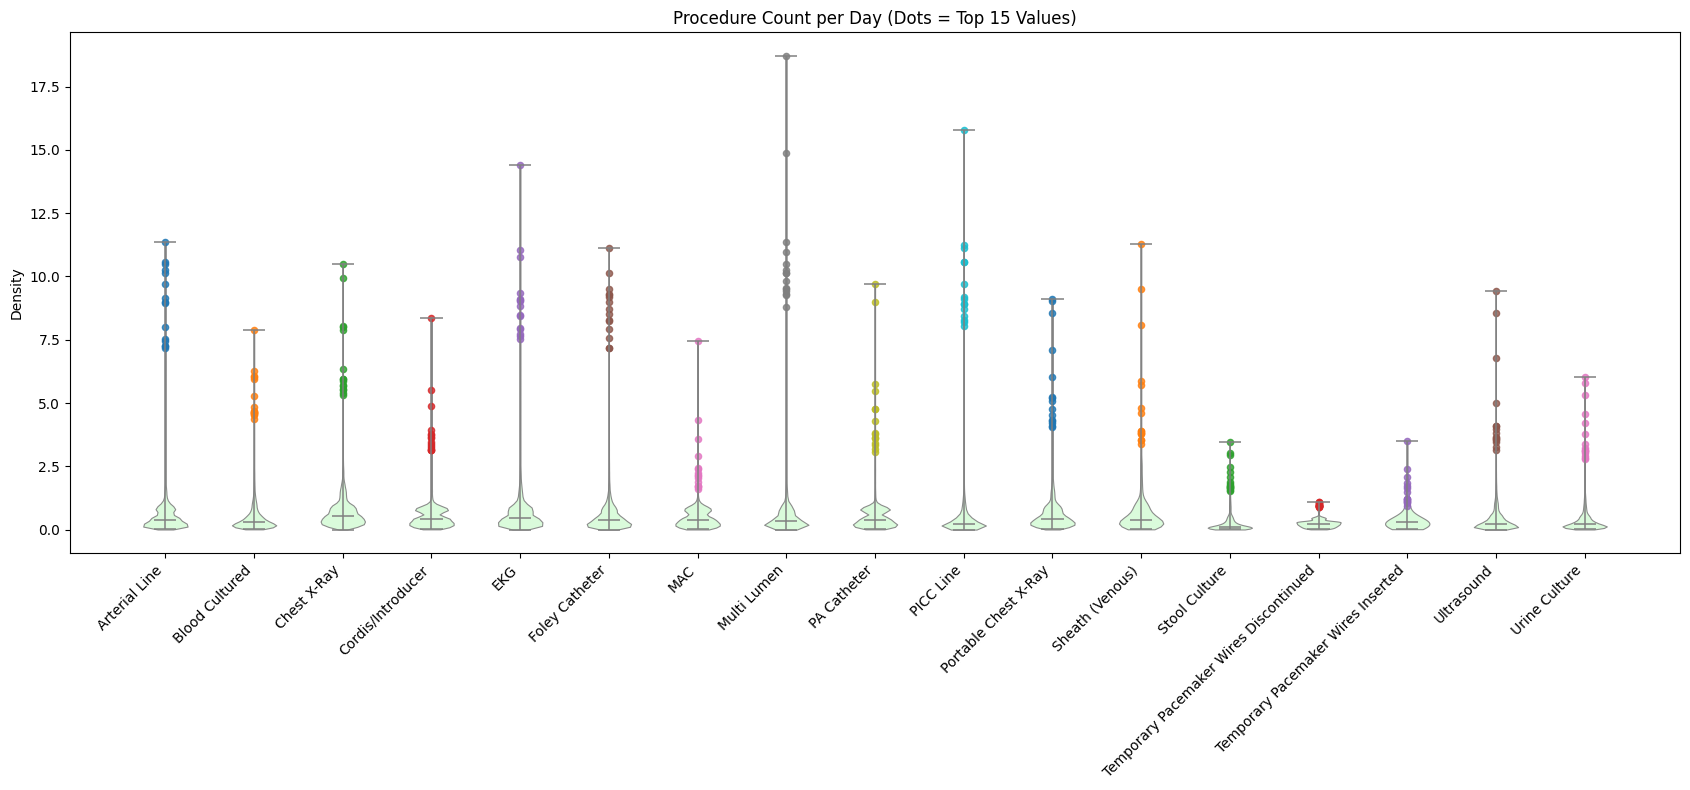

In [ ]:
plot_density_violin(df_density_pre_dni)